# VQC vs MLP

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

In [6]:
import numpy as np
import torch

def plot_decision_boundary(model, X, y, title, is_torch=False):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]

    if is_torch:
        with torch.no_grad():
            Z = model(torch.tensor(grid, dtype=torch.float32)).numpy()
    else:
        Z = model.predict_proba(grid)[:, 1]

    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,4))
    plt.contourf(xx, yy, Z, levels=30, cmap="coolwarm", alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=25, edgecolor="k")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

In [7]:
def evaluate_model(model, X_train, y_train, X_test, y_test, epochs=150):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_fn = torch.nn.BCELoss()

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)

    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        preds = model(X_train_t).squeeze()
        loss = loss_fn(preds, y_train_t)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
        y_pred = (preds > 0.5).int().numpy()

    return (y_pred == y_test).mean()


In [8]:
def evaluate_mlp(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

### Creating Data

**Circles**

In [9]:
X_circles, y_circles = make_circles(
    n_samples=2000,
    noise=0.3,
    factor=0.6,
    random_state=42
)

X_circles = StandardScaler().fit_transform(X_circles)

X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(
    X_circles, y_circles, test_size=0.3, random_state=42
)

**Moons**

In [10]:
X_moons, y_moons = make_moons(
    n_samples=2000,
    noise=0.3,
    random_state=42
)

X_moons = StandardScaler().fit_transform(X_moons)

X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=42
)

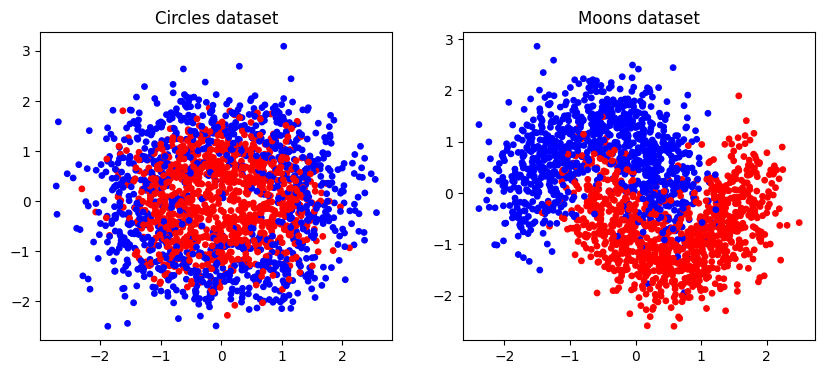

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='bwr', s=15)
axes[0].set_title("Circles dataset")

axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='bwr', s=15)
axes[1].set_title("Moons dataset")

plt.show()


### MLP baseline (классическая нейросеть)

In [12]:
mlp = MLPClassifier(
    hidden_layer_sizes=(8,),
    activation="relu",
    solver="adam",
    max_iter=2000,
    random_state=42
)

In [13]:
mlp_acc_circles = evaluate_mlp(mlp, X_circles_train, y_circles_train, X_circles_test, y_circles_test)
mlpp_acc_moons = evaluate_mlp(mlp, X_moons_train, y_moons_train, X_moons_test, y_moons_test)

mlp_acc_circles, mlpp_acc_moons

(0.7283333333333334, 0.905)

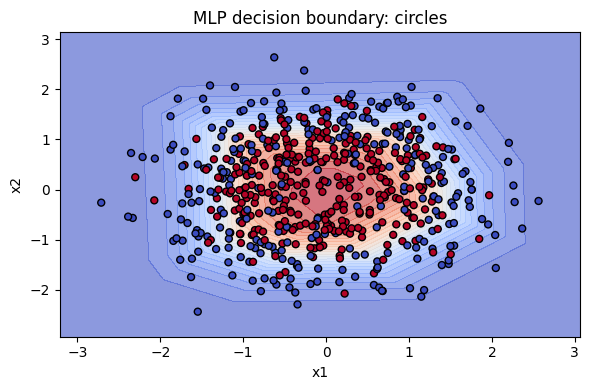

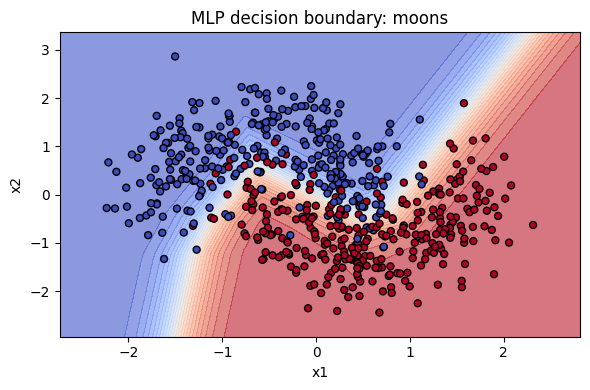

In [14]:
mlp.fit(X_circles_train, y_circles_train)
plot_decision_boundary(
    mlp,
    X_circles_test,
    y_circles_test,
    title="MLP decision boundary: circles"
)


mlp.fit(X_moons_train, y_moons_train)
plot_decision_boundary(
    mlp,
    X_moons_test,
    y_moons_test,
    title="MLP decision boundary: moons"
)

### Суть вариационной квантовой схемы (VQC)

**Variational Quantum Classifier (VQC)** — это квантово-классическая модель машинного обучения, в которой классификация осуществляется с помощью параметризованной квантовой схемы, оптимизируемой градиентными методами.

В общем виде модель можно представить как отображение

$$
x \xrightarrow{\text{embedding}} |\psi(x)\rangle
:\xrightarrow{\text{parametrized circuit}}
:\xrightarrow{\text{measurement}}
\hat{y}
$$

где:

* $x \in \mathbb{R}^d$ — входной вектор признаков,
* $|\psi(x)\rangle$ — квантовое состояние, кодирующее входные данные,
* $\hat{y}$ — предсказание модели.



#### Что происходит математически

**1. Кодирование данных (AngleEmbedding)**
```
Классические данные (x₁, x₂) → Квантовое состояние
```
Каждое число становится углом вращения кубита:
$$|ψ\rangle = R_Y(x_1)|0\rangle_1 \otimes R_Y(x_2)|0\rangle_2$$

**2. Вариационные слои (StronglyEntanglingLayers)**

Для каждого слоя:
- **Вращения**: 3 угла (θ₁, θ₂, θ₃) поворачивают каждый кубит произвольным образом
- **CNOT**: запутывает кубиты → они начинают "влиять друг на друга"

Итого: 2 слоя × 2 кубита × 3 угла = **12 обучаемых параметров**

**3. Измерение**
```
Квантовое состояние → Число в [-1, 1]
```
$$\langle Z_0 \rangle = P(\text{кубит в }|0\rangle) - P(\text{кубит в }|1\rangle)$$

**4. Sigmoid**
```
[-1, 1] → [0, 1] (вероятность класса)
```

#### Физический смысл

- **Вращения** = настраиваемые фильтры для признаков
- **Запутывание** = нелинейное взаимодействие между признаками (как скрытые слои в нейросети)
- **Измерение** = проекция результата в классическое число

#### Почему это "квантовое"?

Квантовое запутывание позволяет 2 кубитам исследовать **4-мерное** пространство состояний одновременно, а не по очереди. Для n кубитов — это $2^n$ измерений, что дает потенциальное преимущество.

#### Обучение

Градиенты вычисляются квантовым способом:
$$\frac{\partial f}{\partial θ} = \frac{f(θ + π/2) - f(θ - π/2)}{2}$$

Запускаем схему с чуть разными углами, сравниваем результаты — получаем направление для оптимизации.

---

**Вся схема**: данные → квантовое кодирование → параметризованные унитарные преобразования с запутыванием → измерение → классическая функция активации → предсказание

In [15]:
import pennylane as qml
import torch
import torch.nn as nn

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits) # Используем квантовый симулятор

# Квантовая схема
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits)) # Embedding (кодирование признаков): каждый признак -> угол вращения
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits)) # Ansatz (вариационная схема): аналог скрытых слоев нейросети
    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (2, n_qubits, 3)}
quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes) # Оборачивание в PyTorch слой

model = nn.Sequential(
    quantum_layer,
    nn.Sigmoid() # Вероятность класса
)

In [16]:
evaluate_model(model, X_circles_train, y_circles_train, X_circles_test, y_circles_test)

np.float64(0.6483333333333333)

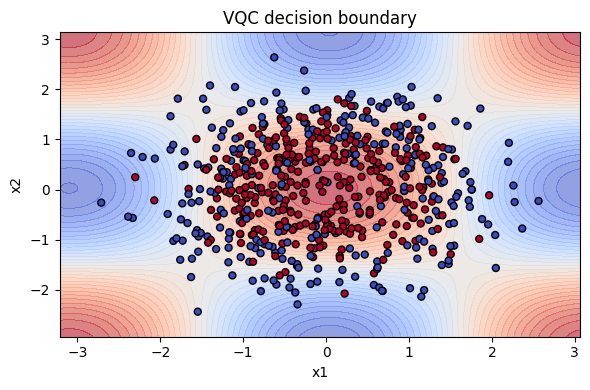

In [17]:
plot_decision_boundary(
    model,
    X_circles_test,
    y_circles_test,
    title="VQC decision boundary",
    is_torch=True
)


In [62]:
import pennylane as qml
import torch
import torch.nn as nn

class VQC(nn.Module):
    def __init__(self, n_qubits=2, dev_name="default.qubit"):
        super(VQC, self).__init__()
        self.n_qubits = n_qubits
        self.dev = qml.device(dev_name, wires=self.n_qubits)

        # Квантовая схема
        @qml.qnode(self.dev, interface="torch")
        def quantum_circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits)) # Embedding (кодирование признаков): каждый признак -> угол вращения
            qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits)) # Ansatz (вариационная схема): аналог скрытых слоев нейросети
            return qml.expval(qml.PauliZ(0))

        weight_shapes = {"weights": (2, self.n_qubits, 3)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes) # Оборачивание в PyTorch слой

        self.model = nn.Sequential(
            self.quantum_layer,
            nn.Sigmoid() # Вероятность класса
        )

    def forward(self, x):
        return self.model(x).squeeze()

    def fit(self, X_train, y_train, epochs=150):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.1)
        loss_fn = torch.nn.BCELoss()

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32)

        self.model.train()
        losses = []
        for _ in range(epochs):
            optimizer.zero_grad()
            preds = self.model(X_train_t).squeeze()
            loss = loss_fn(preds, y_train_t)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        return losses

    def predict(self, X_test):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
            y_pred = (preds > 0.5).int().numpy()

        return y_pred
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return (y_pred == y_test).mean()

**VQC with circles dataset**

In [63]:
vqc_circles = VQC(n_qubits=2)
losses = vqc_circles.fit(X_circles_train, y_circles_train)
y_pred_circles = vqc_circles.predict(X_circles_test)

vqc_score_circles = vqc_circles.score(X_circles_test, y_circles_test)

vqc_score_circles

np.float64(0.645)

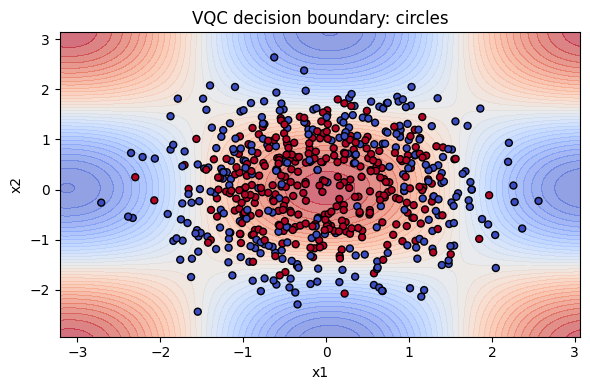

In [64]:
plot_decision_boundary(
    vqc_circles,
    X_circles_test,
    y_circles_test,
    title="VQC decision boundary: circles",
    is_torch=True
)

**VQC with moons dataset**

In [67]:
vqc_moons = VQC(n_qubits=2)
losses = vqc_moons.fit(X_moons_train, y_moons_train)
y_pred_moons = vqc_moons.predict(X_moons_test)

vqc_score_moons = vqc_moons.score(X_circles_test, y_moons_test)

vqc_score_moons

np.float64(0.48333333333333334)

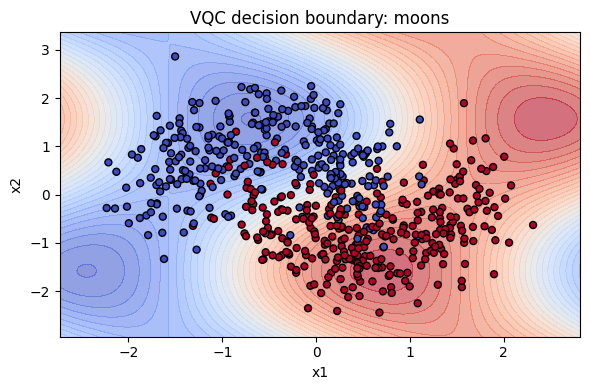

In [68]:
plot_decision_boundary(
    vqc_moons,
    X_moons_test,
    y_moons_test,
    title="VQC decision boundary: moons",
    is_torch=True
)

### VQC - как нелинейный преобразователь признаков

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn


n_qubits = 2
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Feature map: простой нелинейный embedding
def feature_map(x):
    return torch.tensor([x[0], x[1], x[0]*x[1], x[0]**2], dtype=torch.float32)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits)) # Embedding (кодирование признаков): каждый признак -> угол вращения
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits)) # Ansatz (вариационная схема)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers, n_qubits, 3)}
quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

# Гибрид: квантовый слой + классический линейный слой
model_hybrid = nn.Sequential(
    quantum_layer,
    nn.Linear(n_qubits, 1),
    nn.Sigmoid()
)


In [28]:
hybrid_acc_circles = evaluate_model(model_hybrid, X_circles_train, y_circles_train, X_circles_test, y_circles_test)
hybrid_acc_moons = evaluate_model(model_hybrid, X_moons_train, y_moons_train, X_moons_test, y_moons_test)

hybrid_acc_circles, hybrid_acc_moons

(np.float64(0.7366666666666667), np.float64(0.8733333333333333))

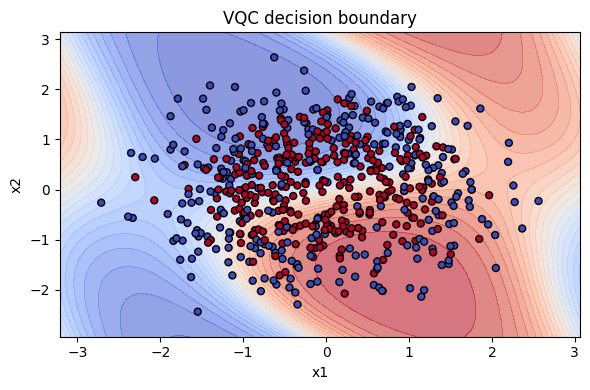

In [29]:
plot_decision_boundary(
    model_hybrid,
    X_circles_test,
    y_circles_test,
    title="VQC decision boundary",
    is_torch=True
)

## Вывод

В первой модели квантовая схема непосредственно реализует классификационную функцию: измерение одного кубита после применения вариационного анзаца напрямую интерпретируется как вероятность принадлежности объекта к классу. Вся выразительная способность модели в этом случае сосредоточена исключительно в квантовой части, а процесс обучения сводится к оптимизации параметров квантовой схемы.

Во второй модели квантовый слой используется иначе: он выступает в роли нелинейного преобразователя признаков, формируя вектор квантовых наблюдаемых, который затем подаётся на вход классического линейного классификатора. Таким образом, квантовая схема не принимает окончательное решение, а выполняет роль обучаемого feature extractor, в то время как финальная классификация осуществляется классической частью модели.

Наблюдаемое увеличение качества во второй архитектуре связано не с квантовым преимуществом как таковым, а с изменением функциональной роли квантового слоя и ростом общей выразительной мощности модели. Добавление классического линейного слоя позволяет более гибко комбинировать квантовые признаки, облегчает оптимизацию и снижает влияние проблем, характерных для чисто квантовых моделей, таких как затухающие градиенты.


In [50]:
import pennylane as qml
import torch
import torch.nn as nn

class VQC(nn.Module):
    def __init__(self, n_qubits=2, dev_name="default.qubit"):
        super(VQC, self).__init__()
        self.n_qubits = n_qubits
        self.dev = qml.device(dev_name, wires=self.n_qubits)

        # Квантовая схема
        @qml.qnode(self.dev, interface="torch")
        def quantum_circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits)) # Embedding (кодирование признаков): каждый признак -> угол вращения
            qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits)) # Ansatz (вариационная схема): аналог скрытых слоев нейросети
            return qml.expval(qml.PauliZ(0))

        weight_shapes = {"weights": (2, self.n_qubits, 3)}
        quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes) # Оборачивание в PyTorch слой

        self.model = nn.Sequential(
            quantum_layer,
            nn.Sigmoid() # Вероятность класса
        )

    def forward(self, x):
        x = self.quantum_layer(x)      # Выход: (batch_size, n_qubits)
        x = self.classical_layer(x)    # Выход: (batch_size, 1)
        return x.squeeze() 

    def fit(self, X_train, y_train, epochs=150):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.1)
        loss_fn = torch.nn.BCELoss()

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32)

        self.model.train()
        losses = []
        for _ in range(epochs):
            optimizer.zero_grad()
            preds = self.model(X_train_t).squeeze()
            loss = loss_fn(preds, y_train_t)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        return losses

    def predict(self, X_test):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
            y_pred = (preds > 0.5).int().numpy()

        return y_pred
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return (y_pred == y_test).mean()

In [51]:
vqc = VQC(n_qubits=2)
losses = vqc.fit(X_circles_train, y_circles_train)
y_pred_circles = vqc.predict(X_circles_test)

vqc_score_circles = vqc.score(X_circles_test, y_circles_test)

vqc_score_circles


np.float64(0.6466666666666666)

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn

class VQC_hybrid(nn.Model):
    def __init__(self, n_qubits=2, n_layers=3, dev_name='default.qubit'):
        self.n_qubits = n_qubits
        self.n_layers = n_layers

        self.dev = qml.device(dev_name, wires=n_qubits)

        # Feature map: простой нелинейный embedding
        def feature_map(x):
            return torch.tensor([x[0], x[1], x[0]*x[1], x[0]**2], dtype=torch.float32)

        @qml.qnode(self.dev, interface="torch")
        def quantum_circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits)) # Embedding (кодирование признаков): каждый признак -> угол вращения
            qml.StronglyEntanglingLayers(weights, wires=range(self.n_qubits)) # Ansatz (вариационная схема)
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

        weight_shapes = {"weights": (self.n_layers, self.n_qubits, 3)}
        quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # Гибрид: квантовый слой + классический линейный слой
        self.model_hybrid = nn.Sequential(
            quantum_layer,
            nn.Linear(n_qubits, 1),
            nn.Sigmoid()
        )

    def fit(self, X_train, y_train, epochs=150):
        optimizer = torch.optim.Adam(self.model_hybrid.parameters(), lr=0.1)
        loss_fn = torch.nn.BCELoss()

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32)

        self.model_hybrid.train()
        losses = []
        for _ in range(epochs):
            optimizer.zero_grad()
            preds = self.model_hybrid(X_train_t).squeeze()
            loss = loss_fn(preds, y_train_t)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        return losses
    

    def predict(self, X_test):
        self.model_hybrid.eval()
        with torch.no_grad():
            preds = self.model_hybrid(torch.tensor(X_test, dtype=torch.float32)).squeeze()
            y_pred = (preds > 0.5).int().numpy()

        return y_pred
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return (y_pred == y_test).mean()


In [43]:
vqc_hybrid = VQC_hybrid()

losses = vqc_hybrid.fit(X_circles_train, y_circles_train)
y_pred_circles = vqc_hybrid.predict(X_circles_test)

vqc_score_circles = vqc_hybrid.score(X_circles_test, y_circles_test)

vqc_score_circles


np.float64(0.7366666666666667)